In [33]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
trait_factor_names_short = ["TF1", "TF2",  "TF3",]



mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Risk',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'Avoidance',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'ThreatPerception',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Deaths", "Cases"]

vars = ["Avoidance", "InforSeek", "Risk", 
        "ThreatPerception", "Worry", "AvoidAnx", "Deaths", "Cases"]


#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception",  "Deaths"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")
# Discretize the numeric vector
bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
df["wave"] = pd.cut(df["session"], bins=bins, labels=labels, right=False, include_lowest=True)

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")
    


def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df

# Trait scores in a separate df
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()

tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)

/data/drive/postdoc/Project4_covid


In [34]:
win=1


for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    regdf = pd.DataFrame()
    for s in np.arange(win+1,21):

        #tdf.loc[:,(dv,[1,2])]
        x_dv = demultindex(tdf.loc[:,(dv,np.arange(s-win,s+1))])
        x_dv = x_dv.rename(columns=dict(zip(x_dv.columns, [dv+"_lag"+str(x) for x in np.arange(win,-1, -1)])))

        x_dv["session"] = s
        x_dv["sess_str"] = "sess"+str(s)
        regdf = pd.concat([regdf, x_dv], axis=0)

    if dvidx == 0:
        fitdf = regdf
    else:
        fitdf = pd.merge(fitdf, regdf,  on=["PROLIFICID", "session"])

bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
fitdf["wave"] = pd.cut(fitdf["session"], bins=bins, labels=labels, right=False, include_lowest=True)

In [35]:

ddf = pd.DataFrame()
for w in ['spring_wave', 'summer', 'autumn_wave']:
    fitdf2=fitdf.loc[fitdf["wave"]==w,:].dropna().reset_index()
    for dvidx, dv in enumerate(vars):
        print(w+"_"+dv)
        eq = mm.generate_equation(dv+"_lag0",  ["session"]+list(fitdf.columns[fitdf.columns.str.contains("_lag1")]), [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["p"] = round(res.pvalues, 4)
        edf["session"] = s
        edf["wave"] = w
        edf["iv"] = edf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, edf.reset_index()])


spring_wave_Avoidance
spring_wave_InforSeek
spring_wave_Risk
spring_wave_ThreatPerception
spring_wave_Worry
spring_wave_AvoidAnx
spring_wave_Deaths
spring_wave_Cases
summer_Avoidance
summer_InforSeek
summer_Risk
summer_ThreatPerception
summer_Worry
summer_AvoidAnx
summer_Deaths
summer_Cases
autumn_wave_Avoidance
autumn_wave_InforSeek
autumn_wave_Risk
autumn_wave_ThreatPerception
autumn_wave_Worry
autumn_wave_AvoidAnx
autumn_wave_Deaths
autumn_wave_Cases


In [36]:
# Map variables to IDs
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

ddf = ddf.loc[(ddf['iv'] != ddf["dv"]) & (ddf["dv"]!="Deaths") & (ddf["dv"]!="Cases") & (ddf["p"]<0.05),]
#ddf = ddf.loc[(ddf['iv'] != ddf["dv"]) & (ddf["dv"]!="Deaths") & (ddf["dv"]!="Cases"),]

<AxesSubplot:>

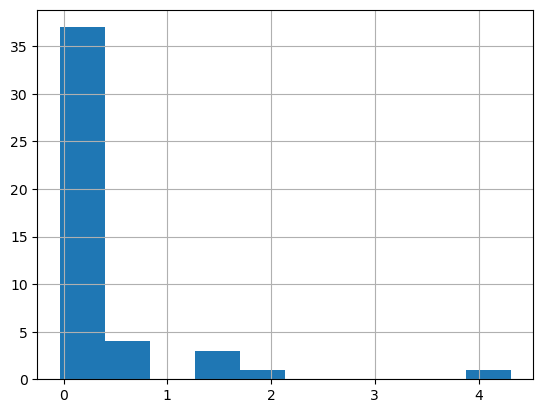

In [37]:
ddf['beta'].hist()

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# Normalize beta values for the colormap, centered on 0 with symmetrical limits


##  Now the same but with traits included

In [39]:
fitdf2=fitdf.loc[fitdf["wave"]=="spring_wave",:].dropna().join(df_id)
fitdf2

Avoidance_lag1  Avoidance_lag0  session sess_str_x  \
PROLIFICID                                                             
01S0stEpc3rU6YxK        0.831601        0.898723        2      sess2   
01S0stEpc3rU6YxK        0.898723        0.947907        3      sess3   
01S0stEpc3rU6YxK        0.947907        0.397123        4      sess4   
01S0stEpc3rU6YxK        0.397123       -0.536981        5      sess5   
01S0stEpc3rU6YxK       -0.536981        0.505957        6      sess6   
...                          ...             ...      ...        ...   
ztPVSoIVH3QKpGeQ        0.416492        0.112175        2      sess2   
ztPVSoIVH3QKpGeQ        0.112175       -0.833919        3      sess3   
ztPVSoIVH3QKpGeQ       -0.833919       -0.932569        4      sess4   
ztPVSoIVH3QKpGeQ       -0.932569       -0.219674        5      sess5   
ztPVSoIVH3QKpGeQ       -0.219674        0.505957        6      sess6   

                  InforSeek_lag1  InforSeek_lag0 sess_str_y  Risk_lag1  \
PROLIFICID                                                               
01S0stEpc3rU6YxK        0.576341        0.797062      sess2  -0.884059   
01S0stEpc3rU6YxK        0.797062        0.977128      sess3  -1.109545   
01S0stEpc3rU6YxK        0.977128       -0.697199      sess4  -1.013366   
01S0stEpc3rU6YxK       -0.697199       -1.289377      sess5  -0.549531   
01S0stEpc3rU6YxK       -1.289377       -1.153094      sess6  -0.228581   
...                          ...             ...        ...        ...   
ztPVSoIVH3QKpGeQ        0.576341        0.797062      sess2  -1.179731   
ztPVSoIVH3QKpGeQ        0.797062        0.977128      sess3   0.841982   
ztPVSoIVH3QKpGeQ        0.977128        1.141432      sess4   0.444115   
ztPVSoIVH3QKpGeQ        1.141432        1.258137      sess5   1.038662   
ztPVSoIVH3QKpGeQ        1.258137        0.482500      sess6   0.565110   

                  Risk_lag0 sess_str_x  ...  Deaths_lag1  Deaths_lag0  \
PROLIFICID                              ...                             
01S0stEpc3rU6YxK  -1.109545      sess2  ...     0.690657    -0.437980   
01S0stEpc3rU6YxK  -1.013366      sess3  ...    -0.437980    -0.809238   
01S0stEpc3rU6YxK  -0.549531      sess4  ...    -0.809238    -0.858142   
01S0stEpc3rU6YxK  -0.228581      sess5  ...    -0.858142    -0.493726   
01S0stEpc3rU6YxK  -0.573867      sess6  ...    -0.493726     0.060650   
...                     ...        ...  ...          ...          ...   
ztPVSoIVH3QKpGeQ   0.841982      sess2  ...     0.777890     0.879307   
ztPVSoIVH3QKpGeQ   0.444115      sess3  ...     0.879307     2.140802   
ztPVSoIVH3QKpGeQ   1.038662      sess4  ...     2.140802     1.042945   
ztPVSoIVH3QKpGeQ   0.565110      sess5  ...     1.042945     3.852338   
ztPVSoIVH3QKpGeQ   0.921647      sess6  ...     3.852338     5.016326   

                 sess_str_x  Cases_lag1  Cases_lag0 sess_str_y         wave  \
PROLIFICID                                                                    
01S0stEpc3rU6YxK      sess2   -0.364614   -0.277128      sess2  spring_wave   
01S0stEpc3rU6YxK      sess3   -0.277128   -0.434583      sess3  spring_wave   
01S0stEpc3rU6YxK      sess4   -0.434583   -0.583652      sess4  spring_wave   
01S0stEpc3rU6YxK      sess5   -0.583652   -0.145731      sess5  spring_wave   
01S0stEpc3rU6YxK      sess6   -0.145731   -0.231037      sess6  spring_wave   
...                     ...         ...         ...        ...          ...   
ztPVSoIVH3QKpGeQ      sess2    0.098821    1.199139      sess2  spring_wave   
ztPVSoIVH3QKpGeQ      sess3    1.199139    0.901199      sess3  spring_wave   
ztPVSoIVH3QKpGeQ      sess4    0.901199    0.651368      sess4  spring_wave   
ztPVSoIVH3QKpGeQ      sess5    0.651368   -0.324689      sess5  spring_wave   
ztPVSoIVH3QKpGeQ      sess6   -0.324689   -1.252985      sess6  spring_wave   

                       TF1       TF2       TF3  
PROLIFICID                                      
01S0stEpc3rU6YxK  0.000099 -0.573207 -0.04

In [40]:
ddf = pd.DataFrame()
for w in ['spring_wave', 'summer', 'autumn_wave']:
    fitdf2=fitdf.loc[fitdf["wave"]==w,:].dropna().join(df_id).reset_index()
    for dvidx, dv in enumerate(vars):
        print(w+"_"+dv)
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
        eq = mm.generate_equation(dv+"_lag0",  ["session", "Avoidance_lag1*TF1"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])


        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["p"] = round(res.pvalues, 4)
        #edf["session"] = s
        edf["wave"] = w
        edf["eff_raw"] = edf.index
        edf['eff_type'] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, edf.reset_index()])

spring_wave_Avoidance


spring_wave_InforSeek
spring_wave_Risk
spring_wave_ThreatPerception
spring_wave_Worry
spring_wave_AvoidAnx
spring_wave_Deaths
spring_wave_Cases
summer_Avoidance
summer_InforSeek
summer_Risk
summer_ThreatPerception
summer_Worry
summer_AvoidAnx
summer_Deaths
summer_Cases
autumn_wave_Avoidance
autumn_wave_InforSeek
autumn_wave_Risk
autumn_wave_ThreatPerception
autumn_wave_Worry
autumn_wave_AvoidAnx
autumn_wave_Deaths
autumn_wave_Cases


In [41]:
# Map variables to IDs


#ddf = ddf.loc[(ddf['iv'] != ddf["dv"]) & (ddf["dv"]!="Deaths") & (ddf["dv"]!="Cases") & (ddf["p"]<0.05),]
#ddf = ddf.loc[(ddf['iv'] != ddf["dv"]) & (ddf["dv"]!="Deaths") & (ddf["dv"]!="Cases"),]

In [42]:
ddf.loc[ddf["eff_type"]=="maineff",:]

index       CI5      CI95      beta         dv       p  \
0        Intercept -0.101702  0.082078 -0.009812  Avoidance  0.8342   
1          session -0.019984  0.022555  0.001286  Avoidance  0.9057   
2   Avoidance_lag1  0.533109  0.750323  0.641716  Avoidance  0.0000   
3              TF1 -0.061155  0.047495 -0.006830  Avoidance  0.8054   
5              TF2 -0.082345  0.003770 -0.039288  Avoidance  0.0737   
..             ...       ...       ...       ...        ...     ...   
21      Worry_lag1 -0.055321  0.053043 -0.001139      Cases  0.9671   
25   AvoidAnx_lag1 -0.110896  0.004582 -0.053157      Cases  0.0712   
29     Deaths_lag1 -0.312355 -0.206361 -0.259358      Cases  0.0000   
33      Cases_lag1  0.657890  0.744220  0.701055      Cases  0.0000   
37       Group Var -0.076968  0.076982  0.000007      Cases  0.9999   

           wave         eff_raw eff_type indiff         iv  
0   spring_wave       Intercept  maineff    NaN  Intercept  
1   spring_wave         session  maineff    NaN    session  
2   spring_wave  Avoidance_lag1  maineff    NaN  Avoidance  
3   spring_wave             TF1  maineff    NaN        TF1  
5   spring_wave             TF2  maineff    NaN        TF2  
..          ...             ...      ...    ...        ...  
21  autumn_wave      Worry_lag1  maineff    NaN      Worry  
25  autumn_wave   AvoidAnx_lag1  maineff    NaN   AvoidAnx  
29  autumn_wave     Deaths_lag1  maineff    NaN     Deaths  
33  autumn_wave      Cases_lag1  maineff    NaN      Cases  
37  autumn_wave       Group Var  maineff    NaN  Group Var  

[336 rows x 11 columns]

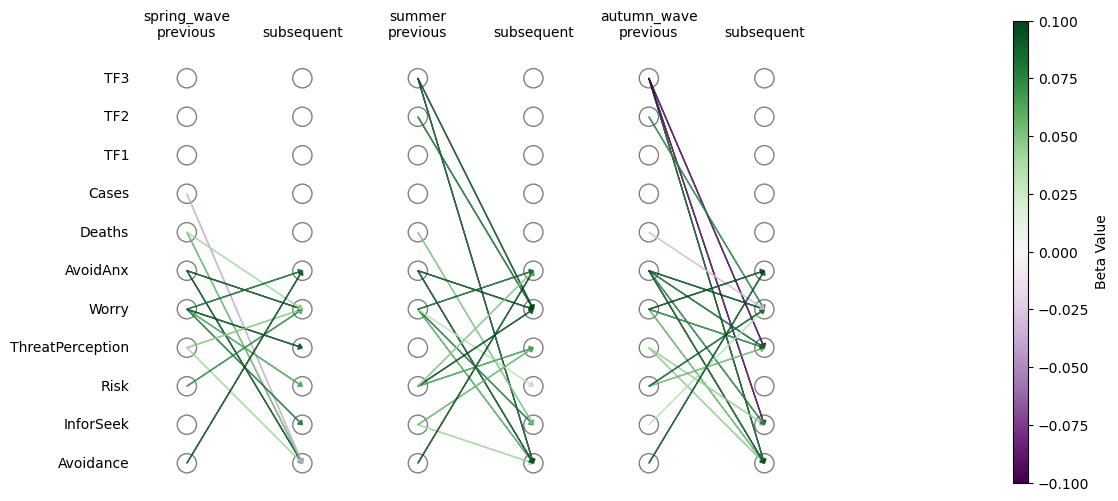

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

var_to_id = {var: i for i, var in enumerate(vars + trait_factor_names_short)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

tddf = ddf.loc[(ddf["eff_type"] == "maineff") & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

# Normalize beta values for the colormap, centered on 0 with symmetrical limits
# max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
max_abs_beta = 0.1
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

# Create a custom colormap
cmap = plt.get_cmap('PRGn')

vars_with_tfs = vars + trait_factor_names_short

# Grid settings
waves = ['spring_wave', 'summer', 'autumn_wave']
n_waves = len(waves)
n_vars = len(vars_with_tfs)
circle_radius = 0.25
arrow_scale = 0.5
within_wave_dist = 3

# Adjust figure size for wider plot
fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

# Draw circles for previous and subsequent columns
for w, wave in enumerate(waves):
    base_x = w * 6  # Increased gap between waves
    for i in range(n_vars):
        ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
        ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

# Draw arrows within each wave
for index, row in tddf.iterrows():
    wave_from = row['wave']
    w = waves.index(wave_from)
    base_x = w * 6
    dv_id = row['dv_id']
    iv_id = row['iv_id']
    beta = row['beta']
    color = cmap(norm(beta))
    ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

# Add variable labels on the left
for i, var in enumerate(vars_with_tfs):
    ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half

# Add wave names and column labels
for w, wave in enumerate(waves):
    base_x = w * 6
    ax.text(base_x, n_vars, wave + "\nprevious", horizontalalignment='center', verticalalignment='bottom')
    ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

# Setting the limits and aspect ratio
ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
ax.set_ylim(-0.5, n_vars + 0.5)
ax.set_aspect('equal')

# Hide the axes
ax.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar with adjusted size and position
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
cbar.set_label('Beta Value')

plt.show()


### Now plot the interactive effects

In [44]:
ddf

index       CI5      CI95      beta         dv       p  \
0            Intercept -0.101702  0.082078 -0.009812  Avoidance  0.8342   
1              session -0.019984  0.022555  0.001286  Avoidance  0.9057   
2       Avoidance_lag1  0.533109  0.750323  0.641716  Avoidance  0.0000   
3                  TF1 -0.061155  0.047495 -0.006830  Avoidance  0.8054   
4   Avoidance_lag1:TF1 -0.010256  0.130842  0.060293  Avoidance  0.0939   
..                 ...       ...       ...       ...        ...     ...   
33          Cases_lag1  0.657890  0.744220  0.701055      Cases  0.0000   
34      Cases_lag1:TF1  0.004269  0.138360  0.071314      Cases  0.0371   
35      Cases_lag1:TF2 -0.097558 -0.003060 -0.050309      Cases  0.0369   
36      Cases_lag1:TF3 -0.101002  0.014061 -0.043471      Cases  0.1386   
37           Group Var -0.076968  0.076982  0.000007      Cases  0.9999   

           wave             eff_raw     eff_type indiff         iv  dv_id  \
0   spring_wave           Intercept      maineff    NaN  Intercept      0   
1   spring_wave             session      maineff    NaN    session      0   
2   spring_wave      Avoidance_lag1      maineff    NaN  Avoidance      0   
3   spring_wave                 TF1      maineff    NaN        TF1      0   
4   spring_wave  Avoidance_lag1:TF1  interaction    TF1  Avoidance      0   
..          ...                 ...          ...    ...        ...    ...   
33  autumn_wave          Cases_lag1      maineff    NaN      Cases      7   
34  autumn_wave      Cases_lag1:TF1  interaction    TF1      Cases      7   
35  autumn_wave      Cases_lag1:TF2  interaction    TF2      Cases      7   
36  autumn_wave      Cases_lag1:TF3  interaction    TF3      Cases      7   
37  autumn_wave           Group Var      maineff    NaN  Group Var      7   

    iv_id  
0     NaN  
1     NaN  
2     0.0  
3     8.0  
4     0.0  
..    ...  
33    7.0  
34    7.0  
35    7.0  
36    7.0  
37    NaN  

[912 rows x 13 columns]

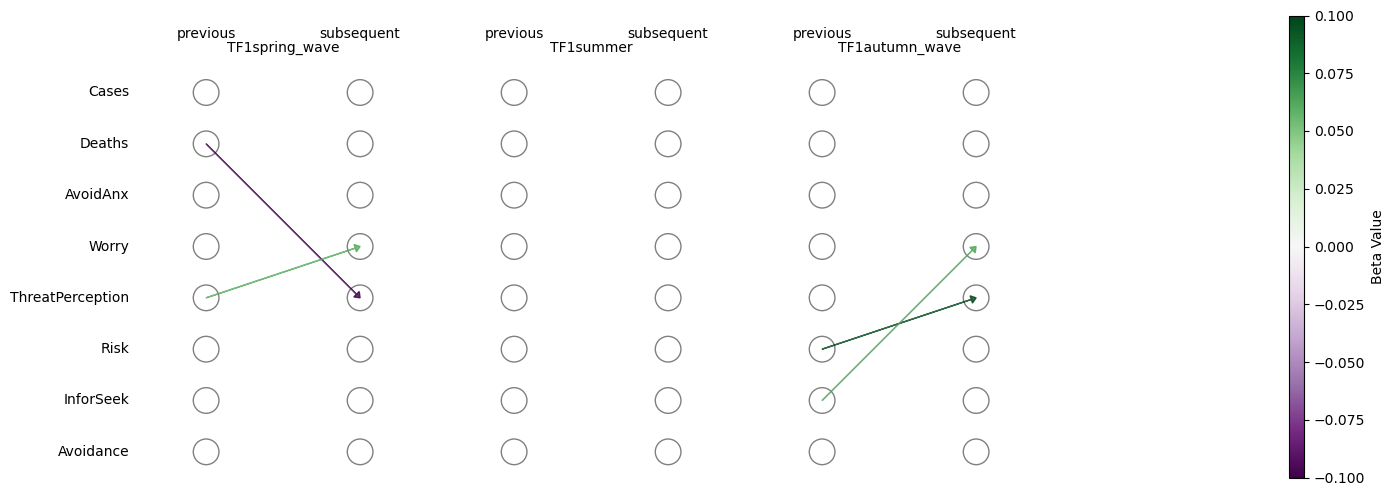

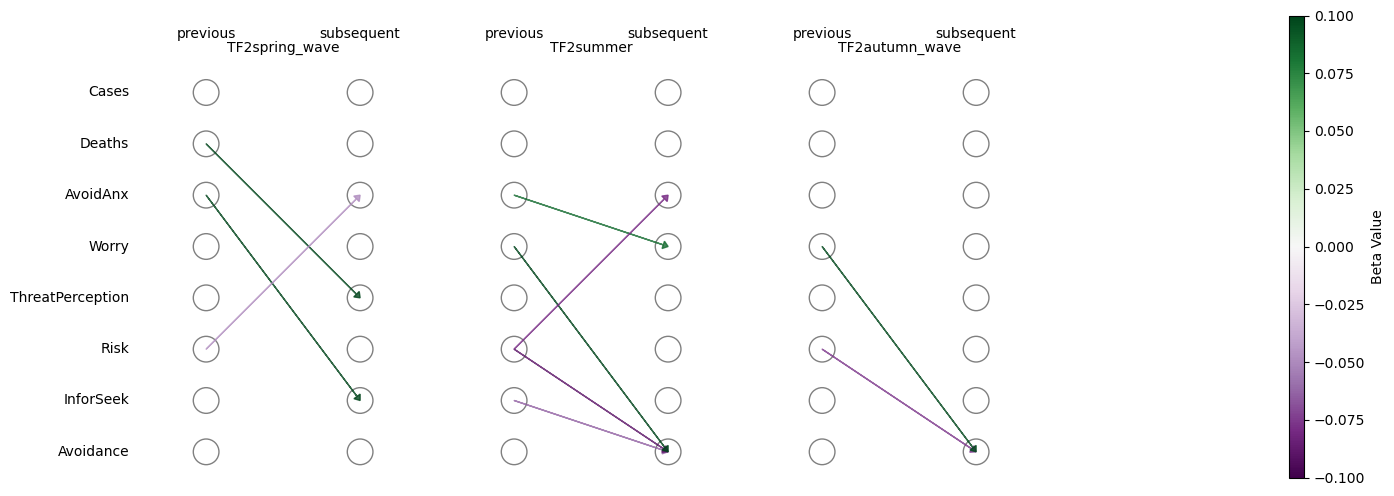

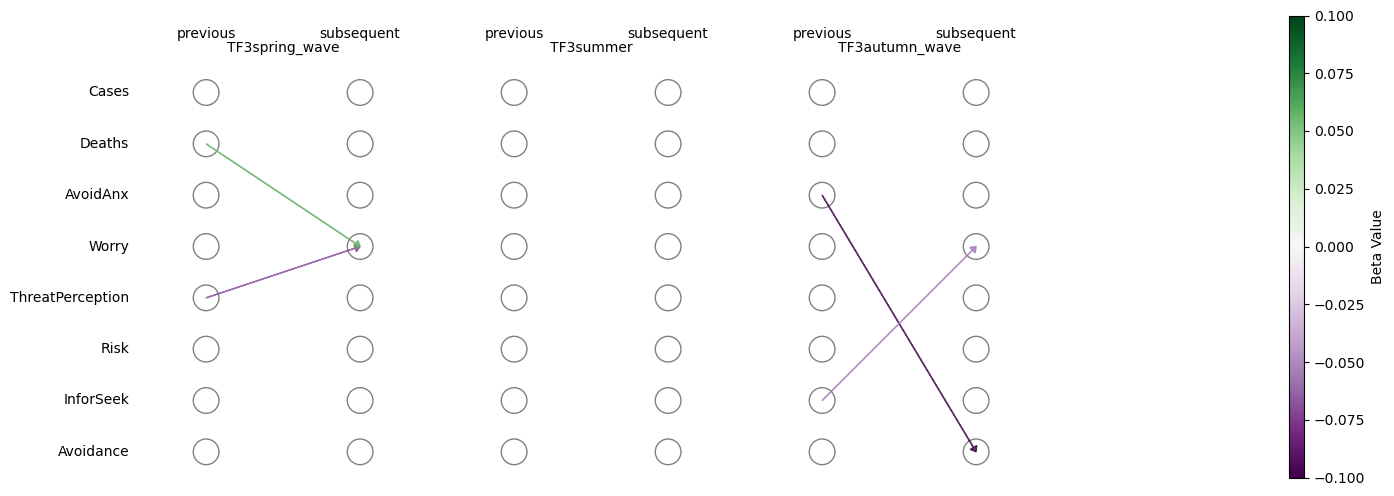

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

var_to_id = {var: i for i, var in enumerate(vars + trait_factor_names_short)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

for id in trait_factor_names_short:
    tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
    #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    max_abs_beta = 0.1
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PRGn')

    vars_with_tfs = vars 

    # Grid settings
    waves = ['spring_wave', 'summer', 'autumn_wave']
    n_waves = len(waves)
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 3

    # Adjust figure size for wider plot
    fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

    # Draw circles for previous and subsequent columns
    for w, wave in enumerate(waves):
        base_x = w * 6  # Increased gap between waves
        for i in range(n_vars):
            ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
            ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

    # Draw arrows within each wave
    for index, row in tddf.iterrows():
        wave_from = row['wave']
        w = waves.index(wave_from)
        base_x = w * 6
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half
    


    # Add wave names and column labels
    for w, wave in enumerate(waves):
        base_x = w * 6
        ax.text(base_x+within_wave_dist/2, n_vars, id+wave , horizontalalignment='center', verticalalignment='top')
        ax.text(base_x, n_vars, "previous", horizontalalignment='center', verticalalignment='bottom')
        ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()

### Across all sessions

In [46]:
ddf = pd.DataFrame()
fitdf2=fitdf.dropna().join(df_id).reset_index()
for dvidx, dv in enumerate(vars):
    dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
    eq = mm.generate_equation(dv+"_lag0",  ["session", "Avoidance_lag1*TF1"]+dvs, [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit(method=['bfgs'])


    edf = res.conf_int(alpha=0.05)
    edf.columns = ["CI5", "CI95"]
    edf["beta"] = res.params
    edf["dv"] = dv 
    edf["p"] = round(res.pvalues, 4)
    #edf["session"] = s
    #edf["wave"] = w
    edf["eff_raw"] = edf.index
    edf['eff_type'] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
    edf["indiff"] = edf.index.str.split(":").str[1]
    edf["iv"] = edf.index.str.split("_").str[0]

    ddf = pd.concat([ddf, edf.reset_index()])

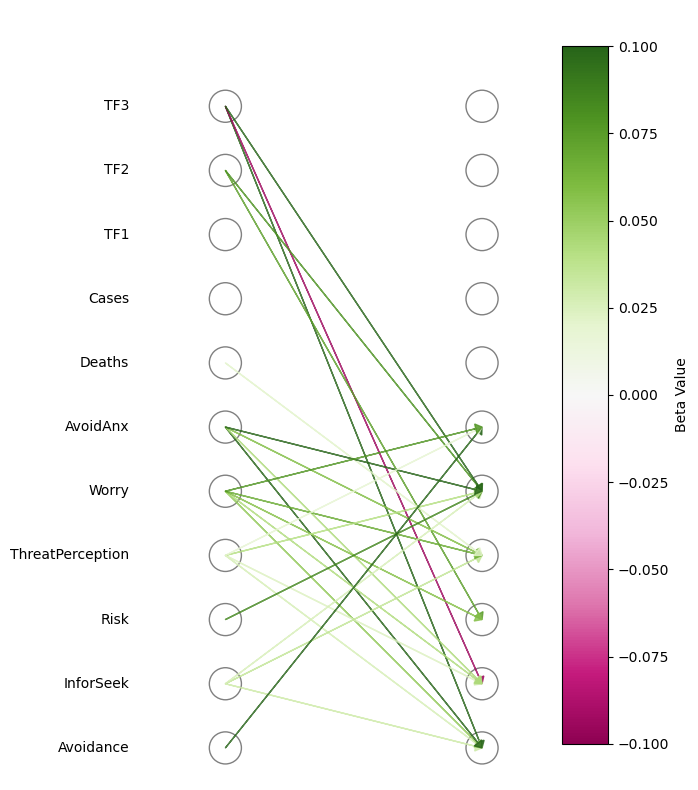

In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

var_to_id = {var: i for i, var in enumerate(vars + trait_factor_names_short)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

tddf = ddf.loc[(ddf["eff_type"] == "maineff") & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

# Normalize beta values for the colormap, centered on 0 with symmetrical limits
max_abs_beta = 0.1
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

# Create a custom colormap
cmap = plt.get_cmap('PiYG')

vars_with_tfs = vars + trait_factor_names_short

# Grid settings
n_vars = len(vars_with_tfs)
circle_radius = 0.25
arrow_scale = 0.5
within_wave_dist = 4

# Adjust figure size for a continuous plot
fig, ax = plt.subplots(figsize=(20, 10))

# Draw circles for previous and subsequent columns
for i in range(n_vars):
    ax.add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
    ax.add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

# Draw arrows within the continuous sequence
for index, row in tddf.iterrows():
    dv_id = row['dv_id']
    iv_id = row['iv_id']
    beta = row['beta']
    color = cmap(norm(beta))
    ax.arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

# Add variable labels on the left
for i, var in enumerate(vars_with_tfs):
    ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')

# Setting the limits and aspect ratio
ax.set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
ax.set_ylim(-0.5, n_vars + 0.5)
ax.set_aspect('equal')

# Hide the axes
ax.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar with adjusted size and position
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
cbar.set_label('Beta Value')

plt.show()


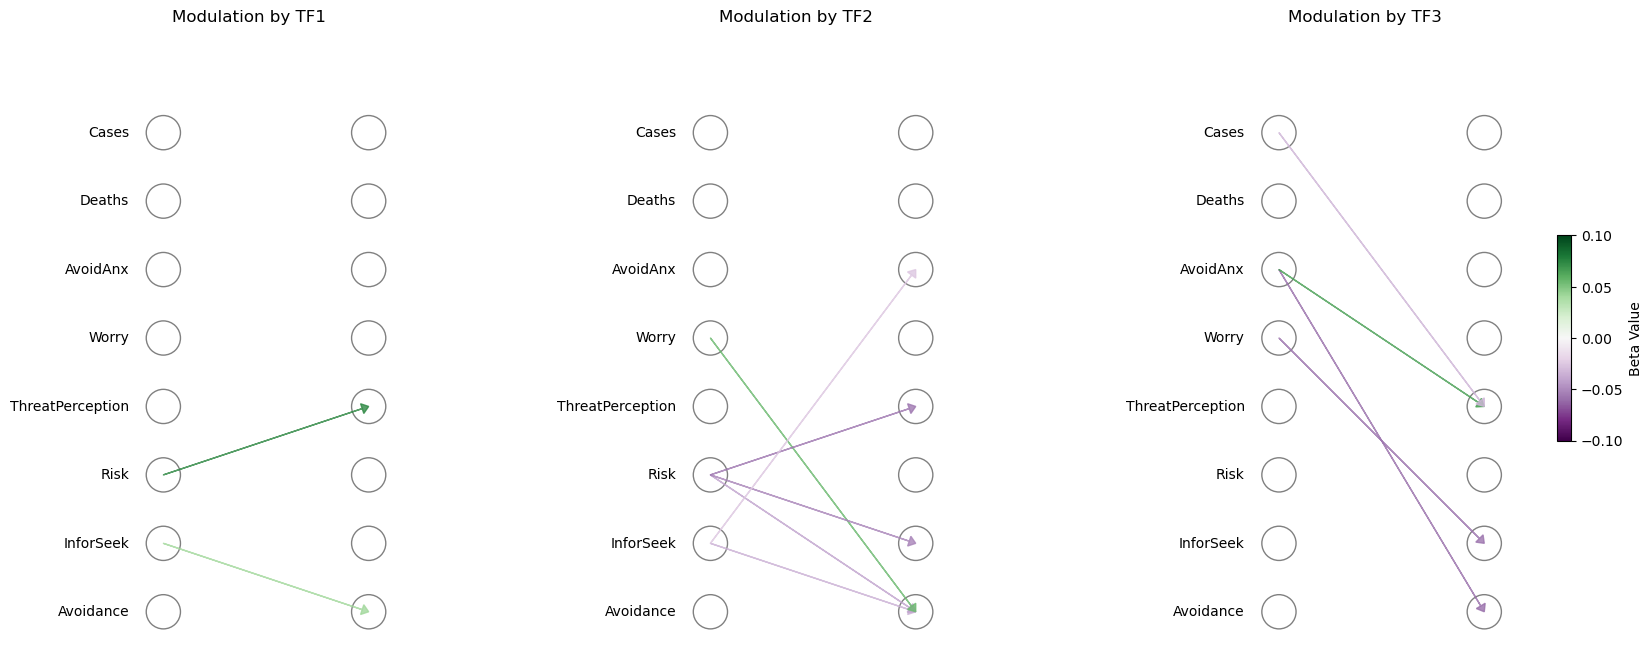

In [48]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

var_to_id = {var: i for i, var in enumerate(vars + trait_factor_names_short)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)
# Adjust figure size for a continuous plot
fig, ax = plt.subplots(1,3,figsize=(20, 8))
for id_idx, id in enumerate(trait_factor_names_short):
    tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    max_abs_beta = 0.1
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PRGn')

    vars_with_tfs = vars 

    # Grid settings
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 3

    

    # Draw circles for previous and subsequent columns
    for i in range(n_vars):
        ax[id_idx].add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
        ax[id_idx].add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

    # Draw arrows within the continuous sequence
    for index, row in tddf.iterrows():
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax[id_idx].arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax[id_idx].text(-0.5, i, var, verticalalignment='center', horizontalalignment='right')
    
    # Add title
    ax[id_idx].set_title("Modulation by "+id)

    # Setting the limits and aspect ratio
    ax[id_idx].set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
    ax[id_idx].set_ylim(-0.5, n_vars + 0.5)
    ax[id_idx].set_aspect('equal')

    # Hide the axes
    ax[id_idx].axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

# Add colorbar with adjusted size and position
cbar = plt.colorbar(sm, ax=ax[2], orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
cbar.set_label('Beta Value')

plt.show()
